In [1]:
#%matplotlib inline
#from matplotlib import style
#style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)
ins = inspect(engine)
col = ins.get_columns('measurement')
for i in col:
    print(i)
print("\n")
col2 = ins.get_columns('station')
for s in col2:
    print(s)

{'name': 'id', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}
{'name': 'station', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'date', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'prcp', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'tobs', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}


{'name': 'id', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}
{'name': 'station', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'name', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'latitude', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 

In [10]:
s = session.query(Station.station).all()
for i in s:
    print(i)

('USC00519397',)
('USC00513117',)
('USC00514830',)
('USC00517948',)
('USC00518838',)
('USC00519523',)
('USC00519281',)
('USC00511918',)
('USC00516128',)


# Exploratory Climate Analysis

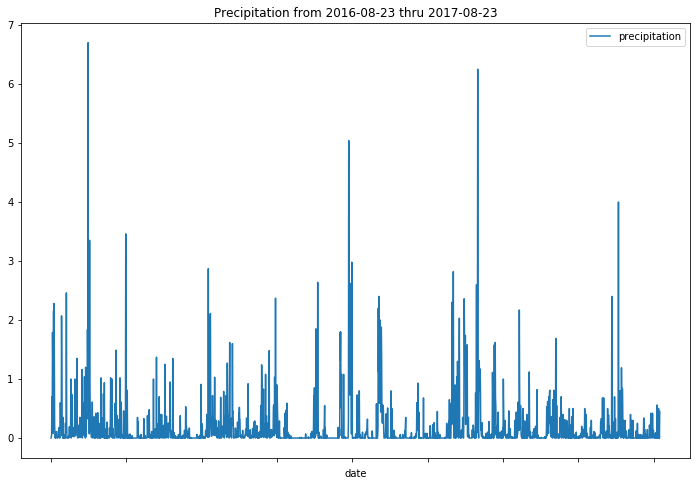

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
s = session.query(Measurement.date).all()
end_date = s[-1][0]
g = end_date.split("-")
start_date = (str(int(g[0]) -1) + "-" + g[1] + "-" + g[2])

# Perform a query to retrieve the data and precipitation scores
rain_data = session.query(Measurement.prcp,Measurement.date).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
rain_df = pd.DataFrame(rain_data,columns=['precipitation','date'])
rain_df.dropna(inplace=True)
rain_df.set_index('date',inplace=True)

# Sort the dataframe by date
rain_df.sort_index(inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
rain_df.plot(figsize=(12,8),title="Precipitation from {} thru {}".format(start_date,end_date))

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
rain_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.name).count()

9

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
for i in session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()):
    print(i)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temp_data = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter_by(station = 'USC00519281').all()
print(temp_data)

[(54.0, 85.0, 71.66378066378067)]


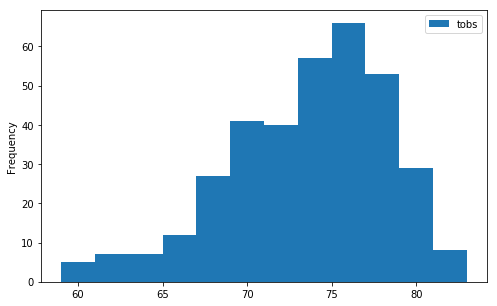

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_temp = session.query(Measurement.station).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).first()
temp_year = session.query(Measurement.tobs,Measurement.date).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).filter(Measurement.station == most_temp[0]).all()
temp_df = pd.DataFrame(temp_year,columns=['tobs','date'])
temp_df.set_index('date',inplace=True)
temp_df.sort_index(inplace=True)
plt.hist(temp_df['tobs'],bins=12,label='tobs')
plt.legend(loc='best')
plt.ylabel('Frequency')
fig = plt.gcf()
fig.set_size_inches(8,5)                                                                                                                  

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_trip='2017-02-01'
end_trip='2017-02-15'
print(calc_temps(start_trip,end_trip))

[(59.0, 69.72448979591837, 80.0)]


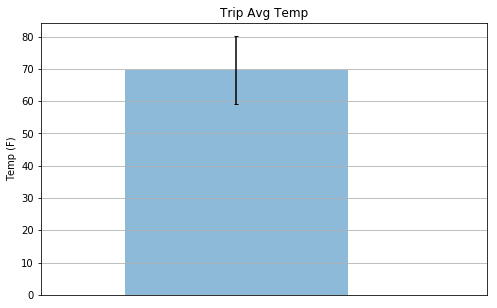

In [19]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

tmin,tavg,tmax=calc_temps(start_trip,end_trip)[0]
x_pos = np.arange(1)
avg_temp=[tavg]
error=[]
error.append(np.std([tmin,tmax]))
plt.bar(x_pos,avg_temp,yerr=error, align='center', alpha=0.5, capsize=2)
plt.xlim(-.7,.9)
plt.xticks([])
plt.title('Trip Avg Temp')
plt.ylabel("Temp (F)")
plt.grid()
fig = plt.gcf()
fig.set_size_inches(8,5)

In [20]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
total_rain = session.query(Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation,func.sum(Measurement.prcp)).filter(Station.station == Measurement.station).filter(Measurement.date >= start_trip).filter(Measurement.date <= end_trip).group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()
for i in total_rain:
    print(i)

('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 7.3100000000000005)
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 6.91)
('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 6.2299999999999995)
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 5.24)
('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 4.43)
('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 3.45)
('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0)


## Optional Challenge Assignment

In [21]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [22]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
st = '2017-02-01'
et = '2017-02-15'
# Use the start and end date to create a range of dates
t_list = pd.date_range(st,et).strftime('%Y-%m-%d').tolist()

# Stip off the year and save a list of %m-%d strings
md_list=[]
for i in t_list:
    l = i.split("-")
    md_list.append("{}-{}".format(l[1],l[2]))

# Loop through the list of %m-%d strings and calculate the normals for each date
day_stats=[]
for i in md_list:
    day_stats.append(daily_normals(i)[0])
day_stats

[(56.0, 68.14035087719299, 78.0),
 (59.0, 68.85964912280701, 77.0),
 (58.0, 67.79661016949153, 77.0),
 (61.0, 68.14035087719299, 76.0),
 (59.0, 69.6842105263158, 80.0),
 (58.0, 70.38983050847457, 77.0),
 (60.0, 69.0, 77.0),
 (56.0, 66.75438596491227, 74.0),
 (57.0, 67.58928571428571, 75.0),
 (56.0, 68.41666666666667, 76.0),
 (61.0, 69.25, 79.0),
 (60.0, 69.15789473684211, 78.0),
 (58.0, 70.36206896551724, 80.0),
 (62.0, 70.89473684210526, 79.0),
 (56.0, 70.28813559322033, 79.0)]

In [23]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_df = pd.DataFrame(day_stats,columns=['tmin','tavg','tmax'])
trip_df['date'] = t_list
trip_df.set_index('date',inplace=True)
trip_df

,tmin,tavg,tmax
date,,,
2017-02-01,56.0,68.140351,78.0
2017-02-02,59.0,68.859649,77.0
2017-02-03,58.0,67.796610,77.0
2017-02-04,61.0,68.140351,76.0
2017-02-05,59.0,69.684211,80.0
2017-02-06,58.0,70.389831,77.0
2017-02-07,60.0,69.000000,77.0
2017-02-08,56.0,66.754386,74.0
2017-02-09,57.0,67.589286,75.0


[Text(0,0,'2017-02-01'),
 Text(0,0,'2017-02-02'),
 Text(0,0,'2017-02-03'),
 Text(0,0,'2017-02-04'),
 Text(0,0,'2017-02-05'),
 Text(0,0,'2017-02-06'),
 Text(0,0,'2017-02-07'),
 Text(0,0,'2017-02-08'),
 Text(0,0,'2017-02-09'),
 Text(0,0,'2017-02-10')]

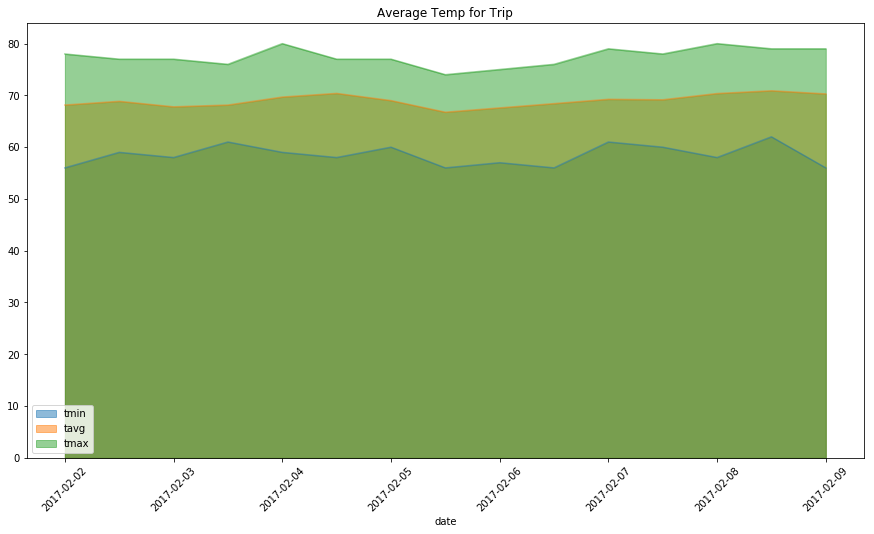

In [25]:
# Plot the daily normals as an area plot with `stacked=False`
t_area = trip_df.plot.area(stacked=False,title='Average Temp for Trip',figsize=(15,8))
t_area.set_xticklabels(t_list,rotation=45)